In [1]:
import warnings
warnings.filterwarnings("ignore")

In [5]:
!pip install numpy==1.26

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.2/18.2 MB 28.0 MB/s eta 0:00:00a 0:00:01
  Attempting uninstall: numpy
    Found existing installation: numpy 2.2.6
    Uninstalling numpy-2.2.6:
      Successfully uninstalled numpy-2.2.6
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
opencv-python 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 1.26.0 which is incompatible.
cellbender 0.3.0 requires nbconvert<7.0.0, but you have nbconvert 7.16.6 which is incompatible.
cellbender 0.3.0 requires notebook<7.0.0, but you have notebook 7.3.2 which is incompatible.
decoupler 1.8.0 requires numba<0.61.0,>=0.60.0, but you have numba 0.58.1 which is incompatible.


In [27]:
import scanpy as sc
import matplotlib.pyplot as plt
import os

In [2]:
import os
import scanpy as sc
import pandas as pd

# Define input and output directories
input_dir = "/data/Datasets/Annotated/TLS_VISIUM/h5ad_preprocessed"
output_dir = "data/TLS_VISIUM/annotations"

# Ensure output directory exists
os.makedirs(output_dir, exist_ok=True)

# List all .h5ad files
for file in os.listdir(input_dir):
    if file.endswith(".h5ad"):
        sample_id = file.replace(".h5ad", "")
        input_path = os.path.join(input_dir, file)
        output_path = os.path.join(output_dir, f"{sample_id}_annotation.csv")
        
        # Load AnnData and extract .obs
        adata = sc.read_h5ad(input_path)
        adata.obs.to_csv(output_path)
        
        print(f"✅ Saved annotations for {sample_id} to {output_path}")

✅ Saved annotations for KC2 to data/TLS_VISIUM/annotations/KC2_annotation.csv
✅ Saved annotations for KC3 to data/TLS_VISIUM/annotations/KC3_annotation.csv
✅ Saved annotations for LC4 to data/TLS_VISIUM/annotations/LC4_annotation.csv
✅ Saved annotations for LC1 to data/TLS_VISIUM/annotations/LC1_annotation.csv
✅ Saved annotations for LC5 to data/TLS_VISIUM/annotations/LC5_annotation.csv
✅ Saved annotations for LC2 to data/TLS_VISIUM/annotations/LC2_annotation.csv
✅ Saved annotations for LC3 to data/TLS_VISIUM/annotations/LC3_annotation.csv
✅ Saved annotations for KC1 to data/TLS_VISIUM/annotations/KC1_annotation.csv


In [7]:
import scanpy as sc
import pandas as pd
import json
import numpy as np
from PIL import Image
import os

def load_fresh_visium_with_annotations(sample_id='KC1'):
    """
    Load fresh Visium data from H5 files with spatial information and annotations
    """
    
    # Read the H5 file
    h5_path = f'/data/Datasets/Annotated/TLS_VISIUM/h5/{sample_id}_filtered_feature_bc_matrix.h5'
    adata = sc.read_10x_h5(h5_path, gex_only=True)
    adata.var_names_make_unique()
    
    print(f"Loaded count matrix: {adata.shape}")
    
    # Load spatial information
    spatial_dir = f'/data/Datasets/Annotated/TLS_VISIUM/10x_Visium/{sample_id}/spatial/'
    
    # Load tissue positions
    positions = pd.read_csv(
        os.path.join(spatial_dir, 'tissue_positions_list.csv'),
        index_col='barcode'
    )
    
    # Load scale factors
    with open(os.path.join(spatial_dir, 'scalefactors_json.json'), 'r') as f:
        scalefactors = json.load(f)
    
    # Set up spatial structure
    adata.uns['spatial'] = {}
    adata.uns['spatial'][sample_id] = {
        'images': {},
        'scalefactors': scalefactors,
        'metadata': {
            'chemistry_description': 'Visium_v1',
            'software_version': 'spaceranger'
        }
    }
    
    # Add spatial information to observations
    adata.obs = adata.obs.join(positions, how='left')
    
    # Add spatial coordinates
    adata.obsm['spatial'] = adata.obs[['pxl_col_in_fullres', 'pxl_row_in_fullres']].values
    
    # Load images with correct key names
    img_path = os.path.join(spatial_dir, 'tissue_hires_image.png')
    if os.path.exists(img_path):
        img = Image.open(img_path)
        adata.uns['spatial'][sample_id]['images']['hires'] = np.array(img)
    
    img_path = os.path.join(spatial_dir, 'tissue_lowres_image.png')
    if os.path.exists(img_path):
        img = Image.open(img_path)
        adata.uns['spatial'][sample_id]['images']['lowres'] = np.array(img)
    
    # Load high-resolution TIF
    tif_path = f'/data/Datasets/Annotated/TLS_VISIUM_USZ/tif_slides/{sample_id}.tif'
    if os.path.exists(tif_path):
        tif_img = Image.open(tif_path)
        adata.uns['spatial'][sample_id]['images']['fullres'] = np.array(tif_img)
    
    # Filter to spots in tissue first
    adata = adata[adata.obs['in_tissue'] == 1].copy()
    print(f"Shape after filtering to in-tissue spots: {adata.shape}")
    
    # Load your saved annotations
    annotation_path = f"data/TLS_VISIUM/annotations/{sample_id}_annotation.csv"
    if os.path.exists(annotation_path):
        print(f"Loading annotations from {annotation_path}")
        annotations = pd.read_csv(annotation_path, index_col=0)
        
        # Get annotation columns (exclude spatial/technical columns)
        annotation_cols = ['manual_anno', 'manual_anno_tls', 'aestetik_manual_anno', 
                          'aestetik_manual_anno_tls', 'ground_truth', 'blur_score']
        
        available_annotation_cols = [col for col in annotation_cols if col in annotations.columns]
        print(f"Found annotation columns: {available_annotation_cols}")
        
        # Add annotations to adata.obs
        for col in available_annotation_cols:
            # Match by barcode index
            matched_values = annotations.reindex(adata.obs.index)[col]
            adata.obs[col] = matched_values
            non_null_count = sum(~matched_values.isna())
            print(f"  {col}: {non_null_count} spots annotated")
    else:
        print(f"No annotation file found at {annotation_path}")
    
    print(f"Final shape: {adata.shape}")
    print(f"Available images: {list(adata.uns['spatial'][sample_id]['images'].keys())}")
    print(f"Annotation columns: {[col for col in adata.obs.columns if 'manual' in col or col in ['ground_truth', 'blur_score']]}")
    
    return adata

In [ ]:
"data/TLS_VISIUM/annotations/KC1_annotation.csv"

In [21]:
# Load a sample with annotations
adata = load_fresh_visium_with_annotations('KC1')

Loaded count matrix: (4173, 17845)
Shape after filtering to in-tissue spots: (4173, 17845)
Loading annotations from data/TLS_VISIUM/annotations/KC1_annotation.csv
Found annotation columns: ['manual_anno', 'manual_anno_tls', 'aestetik_manual_anno', 'aestetik_manual_anno_tls', 'ground_truth', 'blur_score']
  manual_anno: 3690 spots annotated
  manual_anno_tls: 3690 spots annotated
  aestetik_manual_anno: 3690 spots annotated
  aestetik_manual_anno_tls: 3690 spots annotated
  ground_truth: 3690 spots annotated
  blur_score: 3690 spots annotated
Final shape: (4173, 17845)
Available images: ['hires', 'lowres']
Annotation columns: ['manual_anno', 'manual_anno_tls', 'aestetik_manual_anno', 'aestetik_manual_anno_tls', 'ground_truth', 'blur_score']


,in_tissue,array_row,array_col,pxl_row_in_fullres,pxl_col_in_fullres,manual_anno,manual_anno_tls,aestetik_manual_anno,aestetik_manual_anno_tls,ground_truth,blur_score
AAACAACGAATAGTTC-1,1,0,16,477,951,UNASSIGNED,UNASSIGNED,UNASSIGNED,UNASSIGNED,UNASSIGNED,24.097416
AAACAAGTATCTCCCA-1,1,50,102,2658,3095,UNASSIGNED,UNASSIGNED,UNASSIGNED,UNASSIGNED,UNASSIGNED,24.919263
AAACAATCTACTAGCA-1,1,3,43,610,1626,NaN,NaN,NaN,NaN,UNASSIGNED,NaN
AAACACCAATAACTGC-1,1,59,19,3044,1019,UNASSIGNED,UNASSIGNED,UNASSIGNED,UNASSIGNED,UNASSIGNED,24.431286
AAACAGAGCGACTCCT-1,1,14,94,1092,2899,TUM,TUM,TUM,TUM,TUM,23.443533
...,...,...,...,...,...,...,...,...,...,...,...
TTGTTGTGTGTCAAGA-1,1,31,77,1830,2472,NaN,NaN,NaN,NaN,UNASSIGNED,NaN
TTGTTTCACATCCAGG-1,1,58,42,3002,1594,NaN,NaN,NaN,NaN,UNASSIGNED,NaN
TTGTTTCATTAGTCTA-1,1,60,30,3089,1294,UNASSIGNED,UNASSIGNED,UNASSIGNED,UNASSIGNED,UNASSIGNED,27.917364
TTGTTTCCATACAACT-1,1,45,27,2436,1221,UNASSIGNED,UNASSIGNED,UNASSIGNED,UNASSIGNED,UNASSIGNED,21.289857


In [23]:
adata.obs['ground_truth'] = adata.obs['ground_truth'].fillna('UNASSIGNED')

/tmp/ipykernel_50273/2842815913.py:3: FutureWarning: Use `squidpy.pl.spatial_scatter` instead.
  sc.pl.spatial(adata, img_key='hires', color='ground_truth', size=1.5, title=f"Sample {sample_id}")


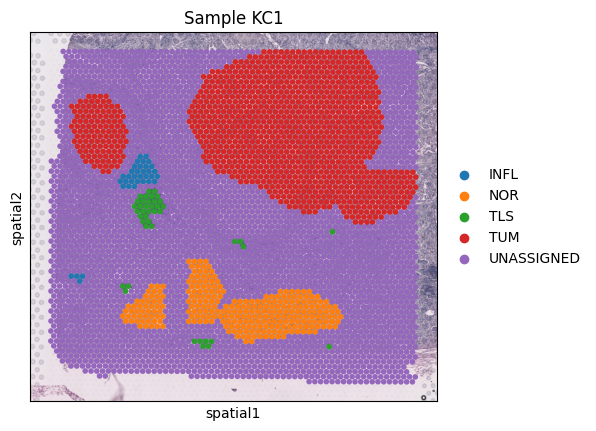

In [25]:
# Quick visualization
sample_id = list(adata.uns['spatial'].keys())[0]
sc.pl.spatial(adata, img_key='hires', color='ground_truth', size=1.5, title=f"Sample {sample_id}")

The output tells us a lot about the dataset:
- We have 3554 spots (observations) and 33,538 genes (features).
- `obs` contains metadata for each spot, such as:
    - 'in_tissue': whether the spot is located within the tissue region
    - 'array_row', 'array_col': spatial grid coordinates
    - 'pxl_row_in_fullres', 'pxl_col_in_fullres': pixel coordinates on the full-resolution WSI
    - Quality metrics like total counts, percent mitochondrial reads, etc.
- `var` contains gene-level metadata like:
    - 'gene_ids', 'featur# Basic spatial plot (may fail if spatial coordinates missing, we'll fix later)
sc.pl.spatial(adata, spot_size=1.2, title="Raw spatial plot")e_types', 'genome'
    - Expression statistics (e.g., mean counts, percent dropout)
- `obsm['spatial']` stores the 2D spatial coordinates for visualization
- `uns['spatial']` includes information about the image itself (e.g., scale, path)

In short: this object contains everything we need to analyze and visualize gene expression spatially.

/tmp/ipykernel_50273/520165166.py:8: FutureWarning: Use `squidpy.pl.spatial_scatter` instead.
  sc.pl.spatial(
/tmp/ipykernel_50273/520165166.py:25: FutureWarning: Use `squidpy.pl.spatial_scatter` instead.
  sc.pl.spatial(


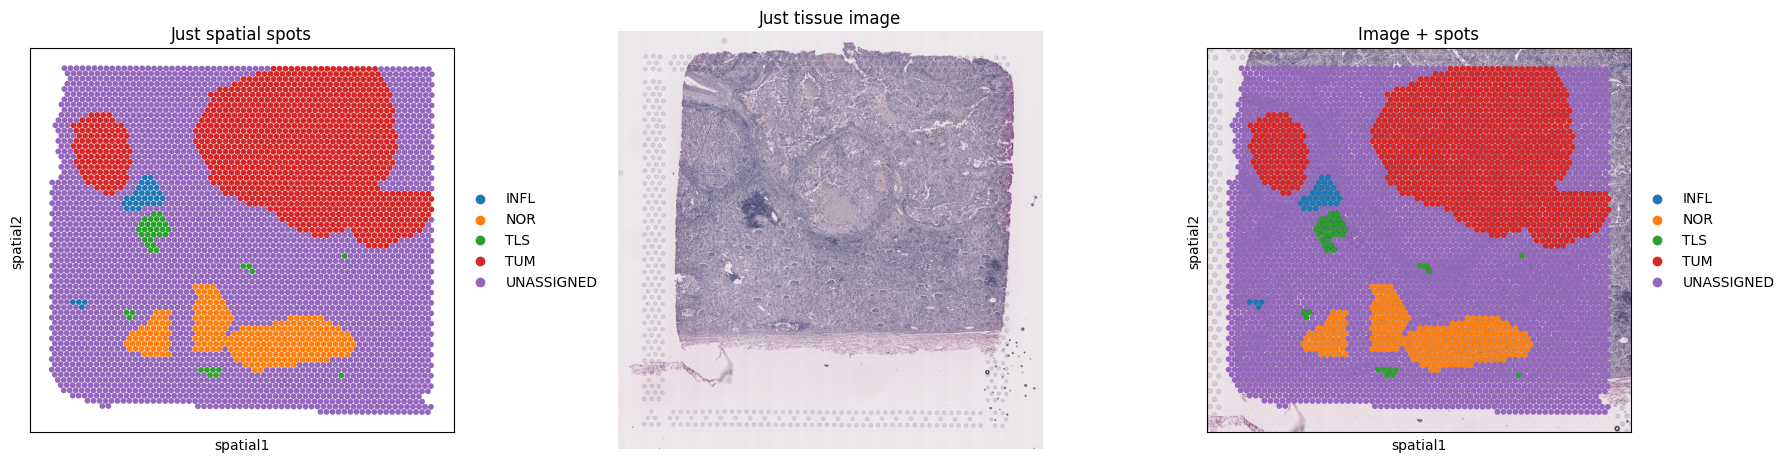

In [28]:
# Choose the correct library_id
library_id = list(adata.uns["spatial"].keys())[0]

# Prepare the figure
fig, axs = plt.subplots(1, 3, figsize=(18, 6))

# Just the spots (no background)
sc.pl.spatial(
    adata,
    library_id=library_id,
    img_key=None,       # No image
    color='ground_truth',
    size=1.5,
    ax=axs[0],
    show=False,
    title="Just spatial spots"
)

# Just the tissue image (manually using the lowres version)
axs[1].imshow(adata.uns["spatial"][library_id]["images"]["hires"])
axs[1].set_title("Just tissue image")
axs[1].axis("off")

# Image + spots
sc.pl.spatial(
    adata,
    library_id=library_id,
    img_key="hires",   # matches key in .uns["spatial"][library_id]["images"]
    color='ground_truth',
    size=1.5,
    ax=axs[2],
    show=False,
    title="Image + spots"
)

plt.tight_layout()
plt.show()

# Quality control

In spatial transcriptomics, we typically filter out low-quality spots based on:
- total_counts: total number of transcripts detected in a spot
- n_genes_by_counts: number of genes detected
- pct_counts_mito: percent of mitochondrial reads (too high = dying cells)

In [ ]:
# Plot common QC metrics: total counts, number of genes, mitochondrial percent
sc.pl.violin(
    adata,
    keys=['total_counts', 'n_genes_by_counts', 'pct_counts_mito'],
    jitter=0.4,
    multi_panel=True,
    rotation=45,
    groupby=None,
    stripplot=True
)

In [ ]:
# Spatial view of QC metrics — helps spot artifacts or damaged areas
sc.pl.spatial(
    adata,
    library_id="ST",
    img_key="downscaled_fullres",
    color=["total_counts", "n_genes_by_counts", "pct_counts_mito"],
    size=1.5,
    cmap="magma"
)

In [ ]:
# Filter out low-quality or potentially problematic spots

# - Spots with too few transcripts (maybe background)
# - Too many transcripts (possible doublets or artifacts)
# - Too few detected genes
# - High mitochondrial gene percentage (dying cells)

sc.pp.filter_cells(adata, min_counts=2000)
sc.pp.filter_cells(adata, max_counts=80000)
sc.pp.filter_cells(adata, min_genes=1000)
adata_tissue = adata_tissue[adata_tissue.obs["pct_counts_mito"] < 20]

print(f"Spots remaining after filtering: {adata.n_obs}")

In [ ]:
# Spatial view of QC metrics — helps spot artifacts or damaged areas
sc.pl.spatial(
    adata,
    library_id="ST",
    img_key="downscaled_fullres",
    color=["total_counts", "n_genes_by_counts", "pct_counts_mito"],
    size=1.5,
    cmap="magma"
)

# Processing

In [ ]:
# Normalize total counts per spot to 10,000, then log1p transform
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)

# Store the raw counts before further processing 
adata.raw = adata

In [ ]:
# Select the top highly variable genes for clustering and dimensionality reduction
sc.pp.highly_variable_genes(adata, flavor="seurat", n_top_genes=2000)

# Filter the object to keep only the HVGs
adata = adata[:, adata.var.highly_variable]

In [ ]:
# Scale each gene to zero mean and unit variance
sc.pp.scale(adata)

# Run PCA to reduce dimensionality
sc.tl.pca(adata, svd_solver='arpack')

# Optional: visualize the explained variance
sc.pl.pca_variance_ratio(adata, log=True)

In [ ]:
# Compute neighborhood graph
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=30)

# Run Leiden clustering (can change resolution to choose better clustering separation. Bigger resolution is more clusters)
sc.tl.leiden(adata, resolution=0.5)

# UMAP embedding for visualization
sc.tl.umap(adata)

# Plot UMAP with cluster labels
sc.pl.umap(adata, color='leiden', title='Leiden clusters')

In [ ]:
# Plot spatial clusters on top of the tissue image
sc.pl.spatial(
    adata,
    library_id="ST",
    img_key="downscaled_fullres",
    color="leiden",
    size=1.5,
    title="Leiden clusters on tissue"
)

# Annotation

We can use different approaches to annotate clusters. I am showing here 2 of them: manual marker-based and an a automatic approach.

## Manual

In [ ]:
# Marker genes grouped by immune cell type
marker_genes = {
    "Pan-immune": ["PTPRC"],

    "B cells": ["MS4A1", "CD79A", "IGHM"],
    
    "T cells": ["CD3D", "CD3E", "CD8A", "CD4"],
    
    "Dendritic cells": ["CLEC9A", "FCER1A"],
    
    "Plasma cells": ["IGHG1", "MZB1"],
    
    "Stromal": ["ACTA2", "PDGFRA", "COL1A1"]  
}

In [ ]:
# Visualize spatial expression for each marker gene

for cell_type, genes in marker_genes.items():
    for gene in genes:
        if gene in adata.var_names:
            sc.pl.spatial(
                adata,
                library_id="ST",
                img_key="downscaled_fullres",
                color=gene,
                size=1.5,
                cmap="plasma",
                title=f"{cell_type} marker: {gene}"
            )
        else:
            print(f"⚠️ Gene {gene} not found in this dataset.")

In [ ]:
# UMAP visualization for key immune markers
sc.pl.umap(
    adata_tissue,
    color=["PTPRC", "CD3D", "CD8A", "MS4A1", "CD79A", "IGHM", "IGHG1"],
    cmap="plasma",
    ncols=4
)

## Automated annotation with Celltypist

In [ ]:
import celltypist
from celltypist import models

# Load pretrained immune model
models.download_models(
    force_update=True, model=["Immune_All_Low.pkl"]
)
model = models.Model.load(model="Immune_All_Low.pkl")
# Run prediction
predictions = celltypist.annotate(adata, model=model, majority_voting=True)

# Save predictions back to AnnData
predictions_adata = predictions.to_adata()
adata.obs["celltypist_cell_label_coarse"] = predictions_adata.obs.loc[
    adata.obs.index, "majority_voting"
]
adata.obs["celltypist_conf_score_coarse"] = predictions_adata.obs.loc[
    adata.obs.index, "conf_score"
]

In [ ]:
# UMAP with Celltypist labels
sc.pl.umap(adata, color="celltypist_cell_label_coarse", title="Celltypist immune cell predictions")

# Or spatial view
sc.pl.spatial(
    adata,
    library_id="ST",
    img_key="downscaled_fullres",
    color="celltypist_cell_label_coarse",
    size=1.5,
    title="Celltypist predictions on tissue"
)

# TLS signature scoring

In [ ]:
# Different TLS-related gene signatures from the literature

tls_signatures = {
    "TLS_12_chemokines": [
        "CCL2", "CCL3", "CCL4", "CCL5", "CCL8", "CCL18",
        "CCL19", "CCL21", "CXCL9", "CXCL10", "CXCL11", "CXCL13"
    ],
    "TLS_good_prognosis_ovarian": [
        "CETP", "CCR7", "SELL", "LAMP3", "CCL19", "CXCL9", "CXCL10", "CXCL11", "CXCL13"
    ],
    "TLS_9gene_set": [
        "CD79B", "CD1D", "CCR6", "LAT", "SKAP1", "CETP", "EIF1AY", "RBP5", "PTGDS"
    ],
    "TLS_hallmark": [
        "CCL19", "CCL21", "CXCL13", "CCR7", "CXCR5", "SELL", "LAMP3"
    ]
}

In [ ]:
# Score each signature and store it in .obs
for name, genes in tls_signatures.items():
    present_genes = [g for g in genes if g in adata_tissue.var_names]
    if len(present_genes) >= 3:  # Minimum 3 to get reliable scores
        sc.tl.score_genes(
            adata_tissue,
            gene_list=present_genes,
            score_name=name + "_score"
        )
    else:
        print(f"⚠️ Skipping {name}: not enough genes found in this dataset")

In [ ]:
# Show spatial heatmaps of each TLS score
for name in tls_signatures:
    score_key = name + "_score"
    if score_key in adata_tissue.obs.columns:
        sc.pl.spatial(
            adata_tissue,
            library_id="ST",
            img_key="downscaled_fullres",
            color=score_key,
            size=1.5,
            cmap="Reds",
            title=f"{name.replace('_', ' ')}"
        )

In [ ]:
# UMAP visualization of all scores
score_keys = [key for key in adata_tissue.obs.columns if key.endswith("_score")]

sc.pl.umap(
    adata_tissue,
    color=score_keys,
    cmap="Reds",
    ncols=2
)

In [2]:
from PIL import Image

# Load the image
image = Image.open("/data/Datasets/Annotated/TLS_VISIUM_USZ/tif_slides/KC1.tif")

# Get size
width, height = image.size
print(f"Width: {width} px, Height: {height} px")

# Total number of pixels
total_pixels = width * height
print(f"Total pixels: {total_pixels:,}")

Width: 10045 px, Height: 9952 px
Total pixels: 99,967,840


/opt/conda/lib/python3.11/site-packages/PIL/Image.py:3402: DecompressionBombWarning: Image size (99967840 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
